#code

## 1. Setup & Config

In [ ]:
import random
from dataclasses import dataclass, asdict
from typing import List, Dict, Optional

# ---------- config ----------

config = {
    "episode_base_name": "Monday_11AM",
    "num_classrooms": 6,
    "attendance": [60, 45, 20, 80, 35, 50],
    "bottleneck": {
        "capacity_per_minute": 40,
        "batch_duration_min": 2
    },
     # Initial slots = 0 for all students
    # Offsets used only during negotiation
    "time_offsets": [0, -2, 2, -4, 4, -6, 6],
    "max_negotiation_rounds": 5,
    "violation_threshold": 1,
    "random_seed": 42
}

random.seed(config["random_seed"])


## 2. Define Message Schemas

In [ ]:
@dataclass
class Offer:
    offer_id: str
    proposer: str
    acceptor: str
    old_offset: int
    shift_min: int
    moved_students: int
    episode_created: int
    counter_to_offer_id: Optional[str] = None

@dataclass
class Commitment:
    commitment_id: str
    proposer: str   # owes
    acceptor: str   # is owed
    shift_min: int
    moved_students: int
    created_episode: int
    due_episode: int
    fulfilled: bool = False
    fulfilled_episode: Optional[int] = None
    times_missed: int = 0


## 3. Bottleneck Agent

In [ ]:
class BottleneckAgent:
    def __init__(self, cfg):
        self.cap_per_min = cfg["bottleneck"]["capacity_per_minute"]
        self.batch_duration = cfg["bottleneck"]["batch_duration_min"]
        self.per_batch = self.cap_per_min * self.batch_duration

    def broadcast_capacity(self, attendance_list, episode_tag):
        total_estimate = sum(attendance_list)
        msg = {"cap_per_min": self.cap_per_min, "total_estimate": total_estimate, "episode_tag": episode_tag}
        print(f"[B] broadcast: per_batch_capacity = {self.per_batch}, total_est={total_estimate}")
        return msg


## 4. Classroom Agent

In [ ]:
class ClassroomAgent:
    def __init__(self, id_, attendance, cfg, professor_willingness=0.7):
        self.id = id_
        self.attendance = attendance
        self.cfg = cfg
        self.personality = random.choice(['prefers_early', 'prefers_late', 'flexible'])
        self.utility_threshold = 0.1 # Agent's minimum acceptable utility
        self.reputation = 1.0
        self.is_stubborn = False
        self.commitment_history: List[Commitment] = []
        # planned_slots stores (offset, students)
        self.planned_slots: List[tuple] = []
        self.per_batch = self.cfg["bottleneck"]["capacity_per_minute"] * self.cfg["bottleneck"]["batch_duration_min"]

    def on_capacity_broadcast(self, msg, index=0):
        self.per_batch = msg["cap_per_min"] * self.cfg["bottleneck"]["batch_duration_min"]
        # INITIAL slots = 0
        self.planned_slots = [(0, self.attendance)]

    def broadcast_schedule(self):
        return {"id": self.id, "slots": list(self.planned_slots)}

    def propose_shift(self, target_agent, congested_offset, current_episode, slot_map: Dict[int, int]):
        best_slot = None
        min_load = float('inf')
        for offset in self.cfg["time_offsets"]:
            if offset == congested_offset:
                continue  # Don't propose shifting to the same slot
            load = slot_map.get(offset, 0)
            if load < min_load:
                min_load = load
                best_slot = offset
        if best_slot is None:
            return None  # No valid slot found to make a proposal
        offer_amount = 0
        for off, cnt in self.planned_slots:
            if off == congested_offset:
                offer_amount = min(cnt, self.per_batch)
                break
        if offer_amount <= 0:
            return None
        offer = Offer(
            offer_id=f"offer_{self.id}_to_{target_agent.id}_ep{current_episode}",
            proposer=self.id,
            acceptor=target_agent.id,
            old_offset=congested_offset,
            shift_min=best_slot - congested_offset,  # DYNAMICALLY calculated shift
            moved_students=offer_amount,
            episode_created=current_episode
        )
        return offer

    def apply_offer(self, offer: Offer):
        old = offer.old_offset
        new = old + offer.shift_min
        moved = offer.moved_students
        updated = False
        new_slots = []
        for off, cnt in self.planned_slots:
            if off == old and not updated:
                move_count = min(cnt, moved)
                remaining = cnt - move_count
                if remaining > 0:
                    new_slots.append((off, remaining))
                moved -= move_count
                updated = True
            else:
                new_slots.append((off, cnt))
        if offer.moved_students - moved > 0:
            # merge into new slot
            merged = []
            found = False
            for off, cnt in new_slots:
                if off == new:
                    merged.append((off, cnt + (offer.moved_students - moved)))
                    found = True
                else:
                    merged.append((off, cnt))
            if not found:
                merged.append((new, offer.moved_students - moved))
            self.planned_slots = merged
        else:
            self.planned_slots = new_slots

    def calculate_utility(self, offer: Offer) -> float:
        """Calculates a score for how good an offer is to this agent."""
        utility = 0.0
        if offer.proposer == self.id: utility += 0.3
        shift_direction = offer.shift_min
        if self.personality == 'prefers_early' and shift_direction < 0: utility += 0.5
        elif self.personality == 'prefers_late' and shift_direction > 0: utility += 0.5
        elif self.personality != 'flexible' and ( (self.personality == 'prefers_early' and shift_direction > 0) or (self.personality == 'prefers_late' and shift_direction < 0) ): utility -= 0.5
        return utility

    def evaluate_offer(self, offer: Offer) -> bool:
        """Returns True if the agent accepts the offer, False otherwise."""
        if self.personality == 'flexible': return True
        return self.calculate_utility(offer) >= self.utility_threshold

    def formulate_counter_offer(self, original_offer: Offer, current_episode: int, slot_map: Dict[int, int]):
        if self.personality == 'flexible': return None
        preferable_offsets = [-2, -4, -6] if self.personality == 'prefers_early' else [2, 4, 6]
        best_alternative_slot, min_load = None, float('inf')
        for offset in preferable_offsets:
            if offset == original_offer.old_offset: continue
            load = slot_map.get(offset, 0)
            if load < min_load:
                min_load, best_alternative_slot = load, offset
        if best_alternative_slot is None: return None
        my_current_offset, offer_amount = self.planned_slots[0][0], min(self.attendance, self.per_batch)
        hypothetical_shift = best_alternative_slot - my_current_offset
        hypothetical_offer = Offer(
            offer_id="hypothetical", proposer=self.id, acceptor=original_offer.proposer,
            old_offset=my_current_offset, shift_min=hypothetical_shift,
            moved_students=offer_amount, episode_created=current_episode
        )
        if self.calculate_utility(hypothetical_offer) < self.utility_threshold:
            print(f"[{self.id}] considered a counter-offer but deemed it not beneficial enough.")
            return None
        print(f"[{self.id}] is formulating a counter-offer...")
        return Offer(
            offer_id=f"counter_{self.id}_to_{original_offer.proposer}_ep{current_episode}",
            proposer=self.id, acceptor=original_offer.proposer, old_offset=my_current_offset,
            shift_min=hypothetical_shift, moved_students=offer_amount,
            episode_created=current_episode, counter_to_offer_id=original_offer.offer_id
        )

In [ ]:
class ClassroomAgent(ClassroomAgent):  # extending previous definition
    def reduce_load_for_fulfillment(self, amount, forbidden_offset, slot_map: Dict[int, int], B_agent, agents_by_id):
        if self.is_stubborn:
            return False
        offsets = [0, -2, 2, -4, 4, -6, 6]  # offsets used for staggered shifting
        for src_index, (src_off, src_cnt) in enumerate(list(self.planned_slots)):
            if src_off == forbidden_offset or src_cnt <= 0:
                continue
            can_take = min(src_cnt, amount)
            for tgt in offsets:
                if tgt == forbidden_offset or tgt == src_off:
                    continue
                if slot_map.get(tgt, 0) + can_take <= B_agent.per_batch:
                    # reduce source
                    self.planned_slots[src_index] = (src_off, src_cnt - can_take)
                    # add to target
                    merged = []
                    added = False
                    for off, cnt in self.planned_slots:
                        if off == tgt:
                            merged.append((off, cnt + can_take))
                            added = True
                        else:
                            merged.append((off, cnt))
                    if not added:
                        merged.append((tgt, can_take))
                    # remove zeros
                    self.planned_slots = [(o,c) for o,c in merged if c>0]
                    slot_map[src_off] = slot_map.get(src_off,0) - can_take
                    slot_map[tgt] = slot_map.get(tgt,0) + can_take
                    return True
        return False

    def fulfill_due_commitments(self, commitments_global: List[Commitment], current_episode: int, slot_map: Dict[int,int],
                                B_agent, agents_by_id: Dict[str, "ClassroomAgent"], violation_threshold: int):
        for com in commitments_global:
            if com.proposer != self.id or com.due_episode != current_episode or com.fulfilled:
                continue
            acceptor_agent = agents_by_id[com.acceptor]
            if len(acceptor_agent.planned_slots) == 0:
                continue
            # target slot for acceptor
            target_slot = acceptor_agent.planned_slots[0][0] + abs(com.shift_min)
            available = B_agent.per_batch - slot_map.get(target_slot, 0)
            to_give = min(com.moved_students, max(0, available))
            if to_give <= 0:
                success = self.reduce_load_for_fulfillment(com.moved_students, forbidden_offset=target_slot,
                                                          slot_map=slot_map, B_agent=B_agent, agents_by_id=agents_by_id)
                if success:
                    available = B_agent.per_batch - slot_map.get(target_slot, 0)
                    to_give = min(com.moved_students, max(0, available))
                else:
                    com.times_missed += 1
                    print(f"[FULFILL FAILED] {self.id} couldn't fulfill {com.commitment_id} (missed {com.times_missed})")
                    if com.times_missed >= violation_threshold:
                        print(f"[VIOLATION] {self.id} exceeded violation threshold for {com.commitment_id}")
                        self.reputation *= 0.8
                    continue
            if to_give > 0:
                freed = self.reduce_load_for_fulfillment(to_give, forbidden_offset=target_slot, slot_map=slot_map,
                                                         B_agent=B_agent, agents_by_id=agents_by_id)
                if freed:
                    merged = []
                    added = False
                    for off, cnt in acceptor_agent.planned_slots:
                        if off == target_slot:
                            merged.append((off, cnt + to_give))
                            added = True
                        else:
                            merged.append((off, cnt))
                    if not added:
                        merged.append((target_slot, to_give))
                    acceptor_agent.planned_slots = merged
                    slot_map[target_slot] = slot_map.get(target_slot,0) + to_give
                    com.fulfilled = True
                    com.fulfilled_episode = current_episode
                    print(f"[FULFILLED] {self.id} fulfilled {com.commitment_id} by giving {to_give} to {acceptor_agent.id} at slot {target_slot}")
                else:
                  com.times_missed += 1
                  print(f"[FULFILL PARTIAL/FAIL] {self.id} couldn't free enough for {com.commitment_id} (missed {com.times_missed})")
                  if com.times_missed >= violation_threshold:
                      print(f"[VIOLATION] {self.id} exceeded violation threshold for {com.commitment_id}. Reputation penalized.")
                      self.reputation *= 0.8

In [ ]:
def compute_slot_map(classrooms: List[ClassroomAgent]) -> Dict[int,int]:
    slot_map = {}
    for c in classrooms:
        for off, cnt in c.planned_slots:
            slot_map[off] = slot_map.get(off, 0) + cnt
    return slot_map


In [ ]:
# Bottleneck
B = BottleneckAgent(config)

# Classrooms
classrooms = [ClassroomAgent(f"C{i+1}", config["attendance"][i], config) for i in range(config["num_classrooms"])]
agents_by_id = {c.id: c for c in classrooms}

classrooms[3].is_stubborn = True # Make C4 stubborn
print(f"System Config: Agent C4 is 'stubborn'. Personalities: {[f'{c.id}:{c.personality}' for c in classrooms]}")
# Global commitments ledger (persists across episodes)
commitments_global: List[Commitment] = []


System Config: Agent C4 is 'stubborn'. Personalities: ['C1:flexible', 'C2:prefers_early', 'C3:prefers_early', 'C4:flexible', 'C5:prefers_late', 'C6:prefers_early']


##  NEGOTIATION SIMULATION

In [ ]:
def run_simulation(num_episodes):
    for ep in range(1, num_episodes+1):
        ep_tag = f"{config['episode_base_name']}_ep{ep}"
        print("\n" + "="*40)
        print(f"RUNNING EPISODE {ep} ({ep_tag})")

        # 1) Broadcast capacity, initial slot assignment = 0
        msg = B.broadcast_capacity(config["attendance"], ep_tag)
        for c in classrooms:
            c.on_capacity_broadcast(msg)

        slot_map = compute_slot_map(classrooms)
        print("[Initial slot map]", slot_map)

        # 2) Fulfill carry-over commitments
        for c in classrooms:
            c.fulfill_due_commitments(commitments_global, current_episode=ep,
                                      slot_map=slot_map, B_agent=B, agents_by_id=agents_by_id,
                                      violation_threshold=config["violation_threshold"])
        slot_map = compute_slot_map(classrooms)
        print("[After fulfill attempts] slot_map:", slot_map)

        # 3) Negotiation rounds
        for round_ in range(config["max_negotiation_rounds"]):
            slot_map = compute_slot_map(classrooms)
            congested_offsets = [off for off, val in slot_map.items() if val > B.per_batch]
            if not congested_offsets:
                print(f"No congestion after negotiation round {round_} in episode {ep}")
                break
            print(f"[Negotiation round {round_}] congested offsets: {congested_offsets}")
            for off in congested_offsets:
                congested_agents = [c for c in classrooms if any(s[0]==off for s in c.planned_slots)]
                if len(congested_agents) < 2:
                    continue
                congested_agents.sort(key=lambda agent: next((s[1] for s in agent.planned_slots if s[0] == off), 0), reverse=True)

                a1 = congested_agents[0]
                a2 = congested_agents[1]

                print(f"[{a1.id}] (most students) is proposing to [{a2.id}].")

                # REPUTATION CHECK
                if a2.reputation < 0.5:
                    print(f"[{a1.id}] refuses to negotiate with {a2.id} due to low reputation ({a2.reputation:.2f}).")
                    continue # a1 skips a2 and the loop continues
                offer = a1.propose_shift(a2, off, ep, slot_map)
                if offer:
                    if a2.evaluate_offer(offer):
                        # --- Offer Accepted ---
                        print(f"[{a1.id}]'s offer to shift by {offer.shift_min} min was ACCEPTED by [{a2.id}].")
                        a2.apply_offer(offer)
                        com = Commitment(
                            commitment_id=f"com_{offer.offer_id}", proposer=offer.proposer, acceptor=offer.acceptor,
                            shift_min=offer.shift_min, moved_students=offer.moved_students,
                            created_episode=ep, due_episode=ep+1
                        )
                        commitments_global.append(com)
                        print(f"[COMMITTED] {com.commitment_id} created, due in episode {ep+1}.")
                    else:
                        # --- Offer Rejected, Initiating Counter-Offer Sequence ---
                        print(f"[{a1.id}]'s offer was REJECTED by [{a2.id}]. Checking for a counter-offer...")
                        counter_offer = a2.formulate_counter_offer(offer, ep, slot_map)

                        if counter_offer:
                            # a2 made a counter-offer. Now a1 must evaluate it.
                            print(f"[{a2.id}] counters with a proposal to shift by {counter_offer.shift_min} min.")
                            if a1.evaluate_offer(counter_offer):
                                # a1 accepts the counter-offer
                                print(f"[{a1.id}] ACCEPTS the counter-offer from [{a2.id}].")
                                a1.apply_offer(counter_offer) # a1 applies the offer to its own schedule
                                com = Commitment(
                                    commitment_id=f"com_{counter_offer.offer_id}",
                                    proposer=counter_offer.proposer, # a2 is now the one who owes
                                    acceptor=counter_offer.acceptor,   # a1 is now the one who is owed
                                    shift_min=counter_offer.shift_min, moved_students=counter_offer.moved_students,
                                    created_episode=ep, due_episode=ep+1
                                )
                                commitments_global.append(com)
                                print(f"[COMMITTED] {com.commitment_id} created from counter-offer, due in episode {ep+1}.")
                            else:
                                # a1 rejects the counter-offer
                                print(f"[{a1.id}] REJECTS the counter-offer from [{a2.id}]. Negotiation ends.")
                        else:
                            # a2 did not provide a counter-offer
                            print(f"[{a2.id}] did not provide a counter-offer. Negotiation ends.")
        slot_map = compute_slot_map(classrooms)
        print("[Final slot_map after episode]", slot_map)
        print("Schedules:")
        for c in classrooms:
            print(f" {c.id}: {c.planned_slots}")

# run 3 episodes
run_simulation(num_episodes=5)



RUNNING EPISODE 1 (Monday_11AM_ep1)
[B] broadcast: per_batch_capacity = 80, total_est=290
[Initial slot map] {0: 290}
[After fulfill attempts] slot_map: {0: 290}
[Negotiation round 0] congested offsets: [0]
[C4] (most students) is proposing to [C1].
[C4]'s offer to shift by -2 min was ACCEPTED by [C1].
[COMMITTED] com_offer_C4_to_C1_ep1 created, due in episode 2.
[Negotiation round 1] congested offsets: [0]
[C4] (most students) is proposing to [C6].
[C4]'s offer was REJECTED by [C6]. Checking for a counter-offer...
[C6] is formulating a counter-offer...
[C6] counters with a proposal to shift by -4 min.
[C4] ACCEPTS the counter-offer from [C6].
[COMMITTED] com_counter_C6_to_C4_ep1 created from counter-offer, due in episode 2.
[Negotiation round 2] congested offsets: [0]
[C6] (most students) is proposing to [C2].
[C6]'s offer was REJECTED by [C2]. Checking for a counter-offer...
[C2] is formulating a counter-offer...
[C2] counters with a proposal to shift by -6 min.
[C6] ACCEPTS the cou

## Visualization

Parsed 5 episodes

EPISODE SUMMARY: 1 (Monday_11AM_ep1)
Broadcast: Capacity=80, Total Students=290

Accepted Direct Proposals (3):
  1. C4 → C1: shift -2 min
  2. C2 → C5: shift +2 min
  3. C2 → C4: shift +4 min

Rejected Direct Proposals (2):
  1. C4 → C6
  2. C6 → C2

Accepted Counter Offers (2):
  1. C6 → C4: shift -4 min
  2. C2 → C6: shift -6 min

Final Schedules:
  C1: offset=-2, size=60
  C2: offset=0, size=45
  C3: offset=0, size=20
  C4: offset=-4, size=50, offset=4, size=30
  C5: offset=2, size=35
  C6: offset=0, size=5, offset=-6, size=45


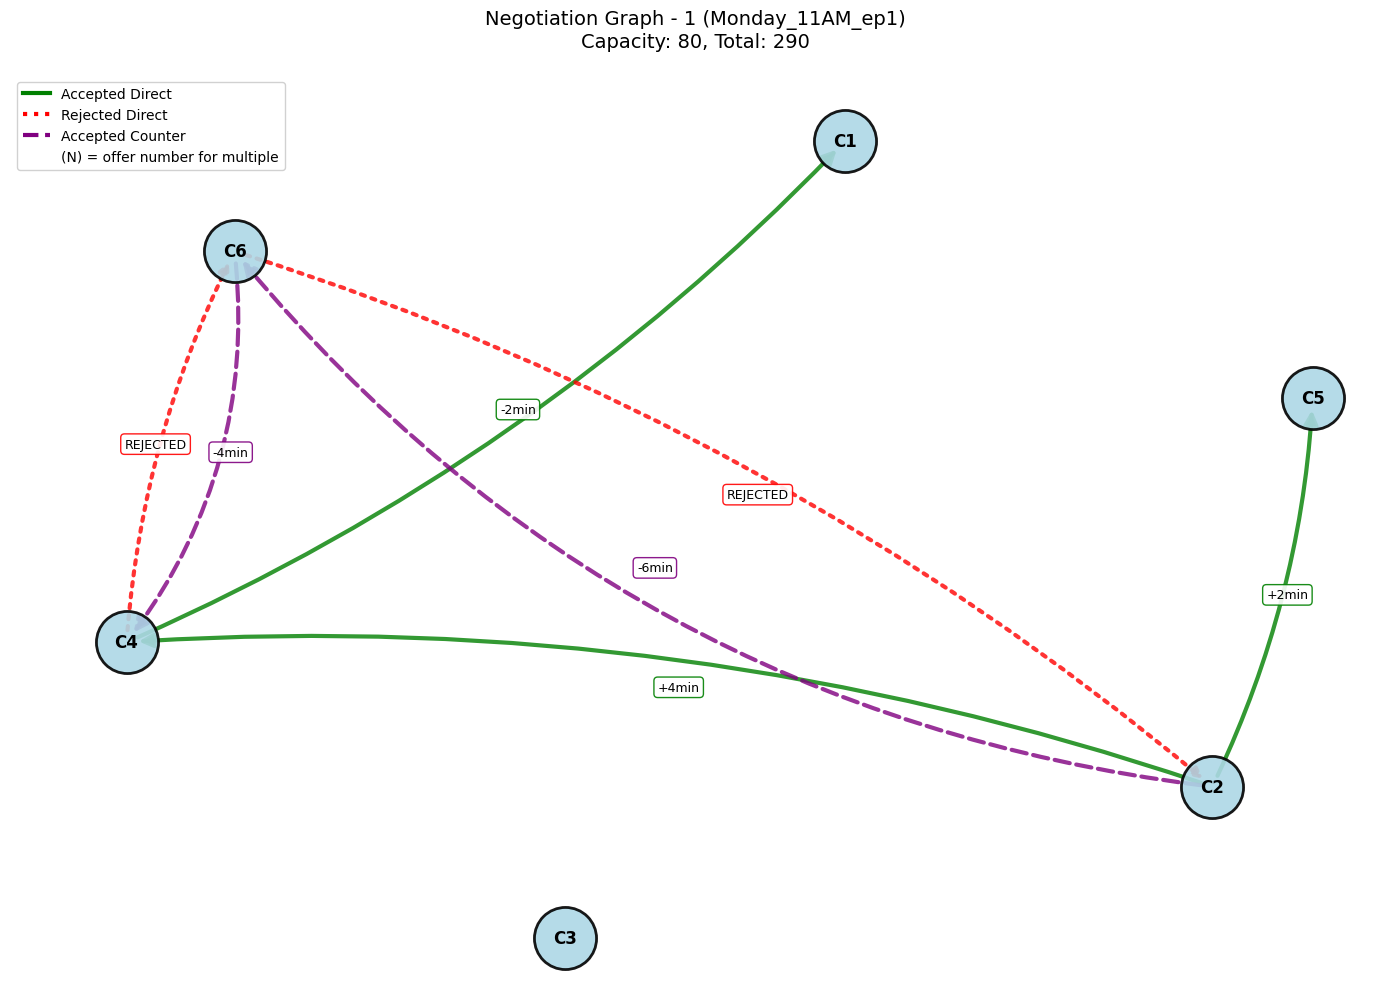

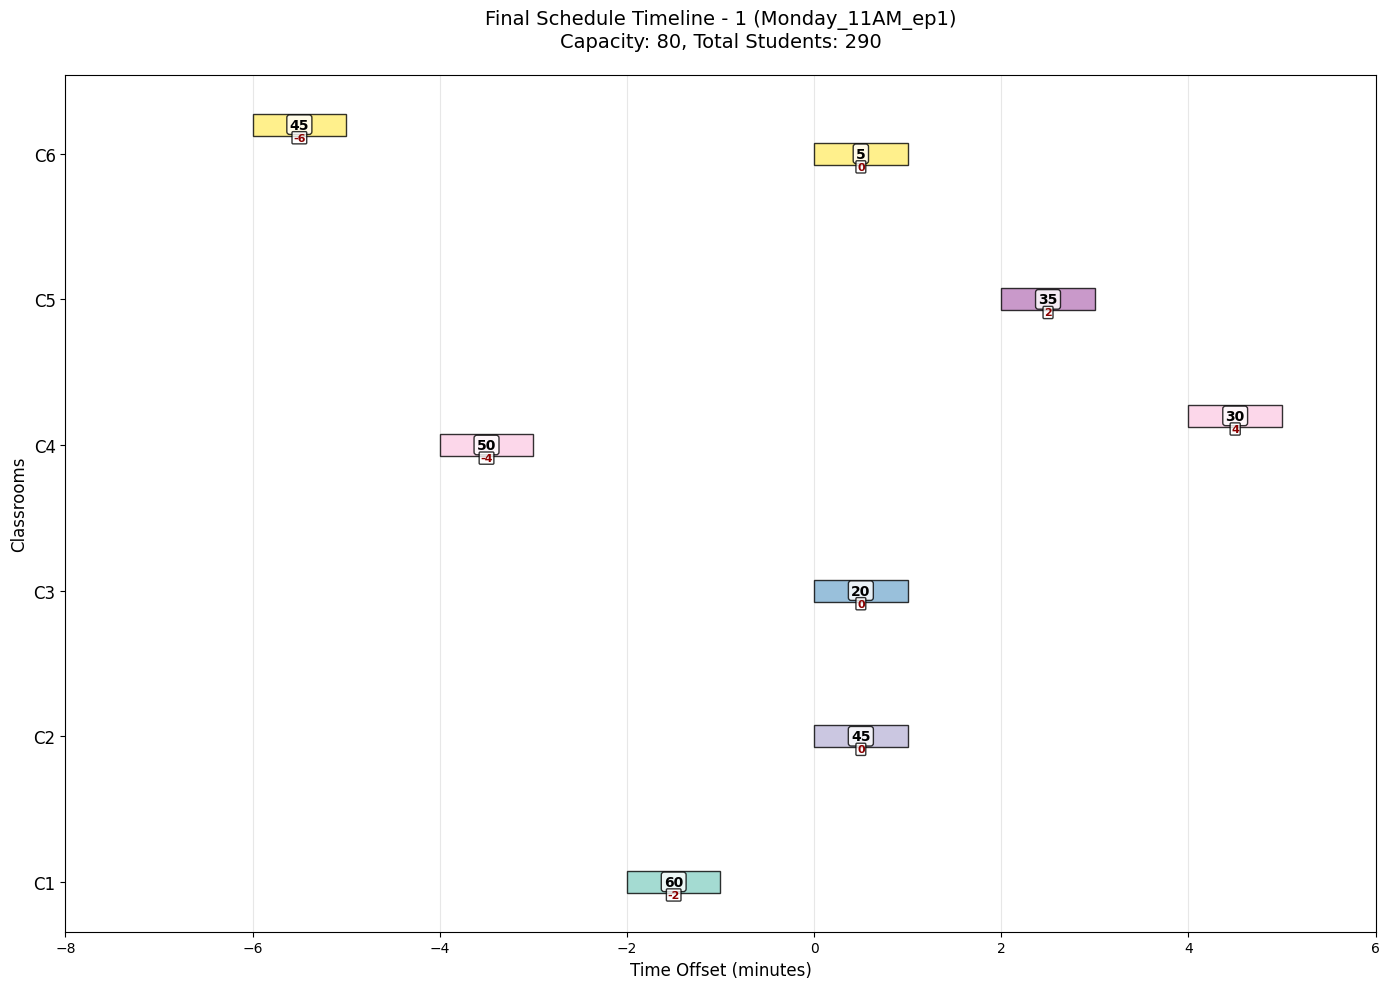


EPISODE SUMMARY: 2 (Monday_11AM_ep2)
Broadcast: Capacity=80, Total Students=290

Multiple Offers Between Pairs (2):
  C4 → C5: 2 offers
    1. direct rejected (shift: N/A)
    2. direct rejected (shift: N/A)
  C5 → C4: 2 offers
    1. counter accepted (shift: 2)
    2. counter accepted (shift: 6)

Accepted Direct Proposals (1):
  1. C4 → C1: shift -4 min

Rejected Direct Proposals (2):
  1. C4 → C5
  2. C4 → C5

Accepted Counter Offers (2):
  1. C5 → C4: shift +2 min
  2. C5 → C4: shift +6 min

Fulfillments (4):
  ✓ C2 fulfilled com_counter_C2_to_C6_ep1 by giving 45 to C6 at slot 6
  ✓ C2 fulfilled com_offer_C2_to_C5_ep1 by giving 45 to C5 at slot 2
  ✓ C2 fulfilled com_offer_C2_to_C4_ep1 by giving 45 to C4 at slot 4
  ✓ C6 fulfilled com_counter_C6_to_C4_ep1 by giving 35 to C4 at slot 4

Violations (1):
  ⚠ C4 exceeded violation threshold for com_offer_C4_to_C1_ep1. Reputation penalized.

Final Schedules:
  C1: offset=-4, size=60
  C2: offset=-2, size=45
  C3: offset=0, size=20
  C4: 

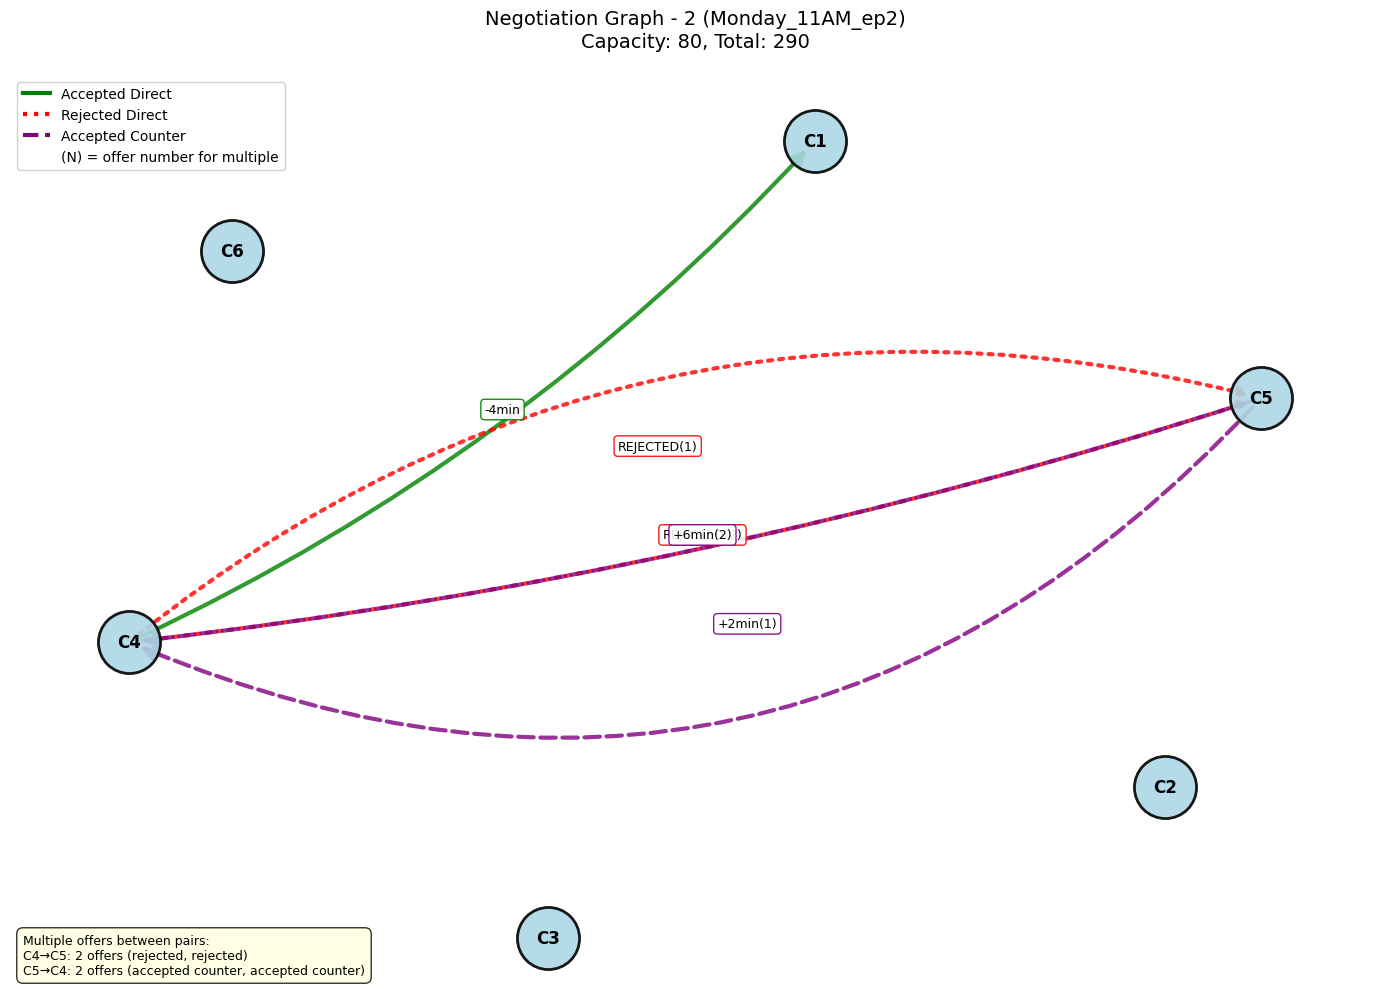

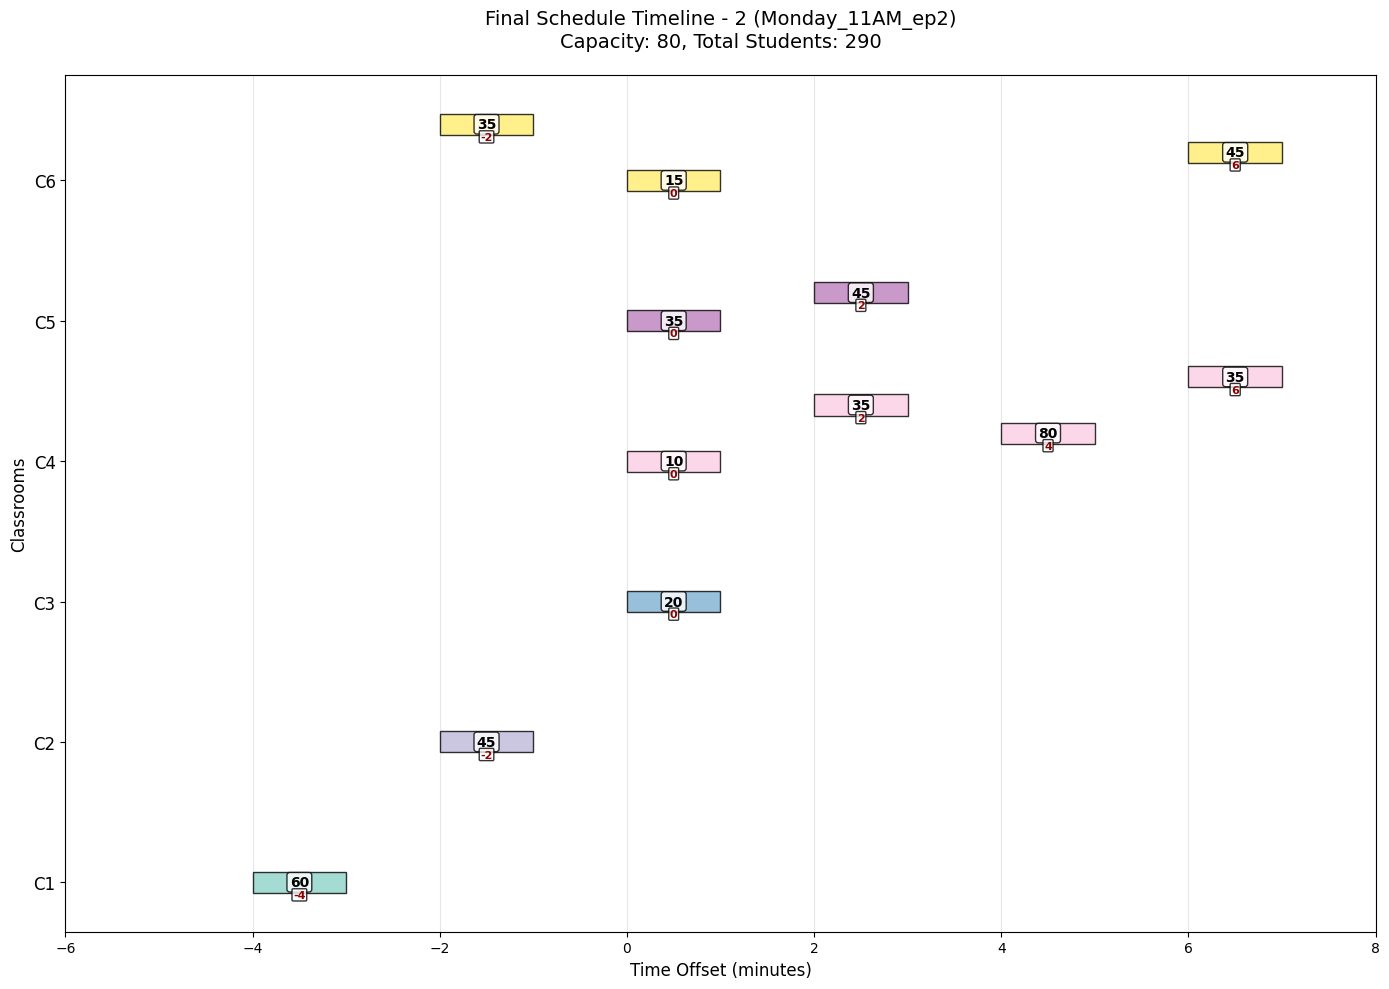


EPISODE SUMMARY: 3 (Monday_11AM_ep3)
Broadcast: Capacity=80, Total Students=290

Multiple Offers Between Pairs (1):
  C2 → C4: 2 offers
    1. counter accepted (shift: -6)
    2. direct accepted (shift: 4)

Accepted Direct Proposals (3):
  1. C4 → C1: shift -2 min
  2. C4 → C6: shift -4 min
  3. C2 → C4: shift +4 min

Rejected Direct Proposals (1):
  1. C4 → C2

Accepted Counter Offers (1):
  1. C2 → C4: shift -6 min

Fulfillments (2):
  ✓ C5 fulfilled com_counter_C5_to_C4_ep2 by giving 35 to C4 at slot 2
  ✓ C5 fulfilled com_counter_C5_to_C4_ep2 by giving 35 to C4 at slot 6

Violations (1):
  ⚠ C4 exceeded violation threshold for com_offer_C4_to_C1_ep2. Reputation penalized.

Final Schedules:
  C1: offset=-2, size=60
  C2: offset=0, size=45
  C3: offset=0, size=20
  C4: offset=2, size=35, offset=6, size=35, offset=-6, size=45, offset=4, size=35
  C5: offset=2, size=35
  C6: offset=-4, size=50


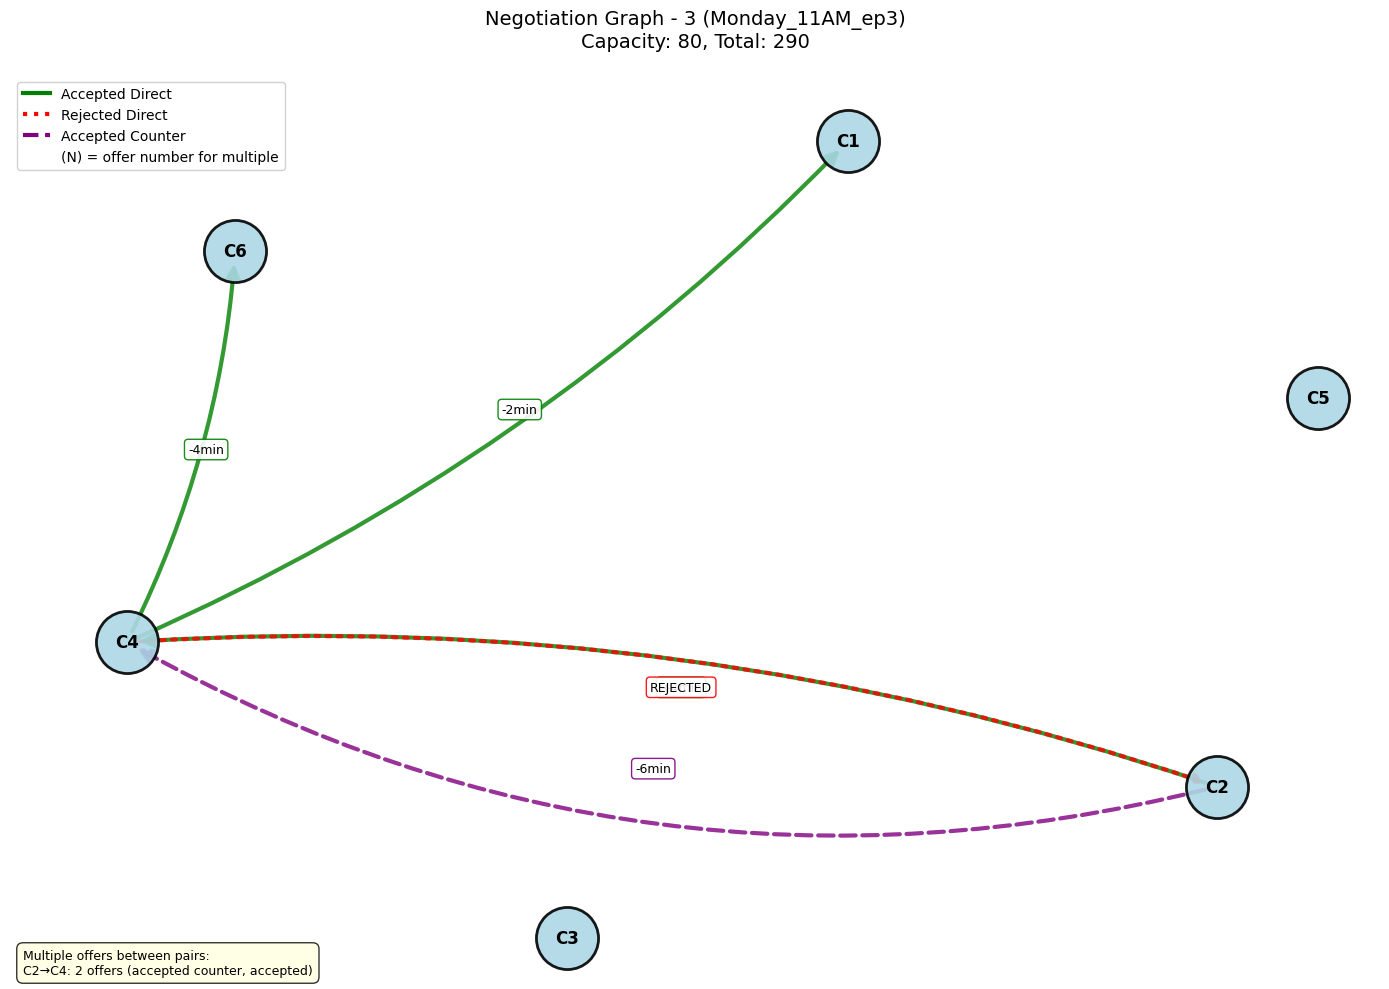

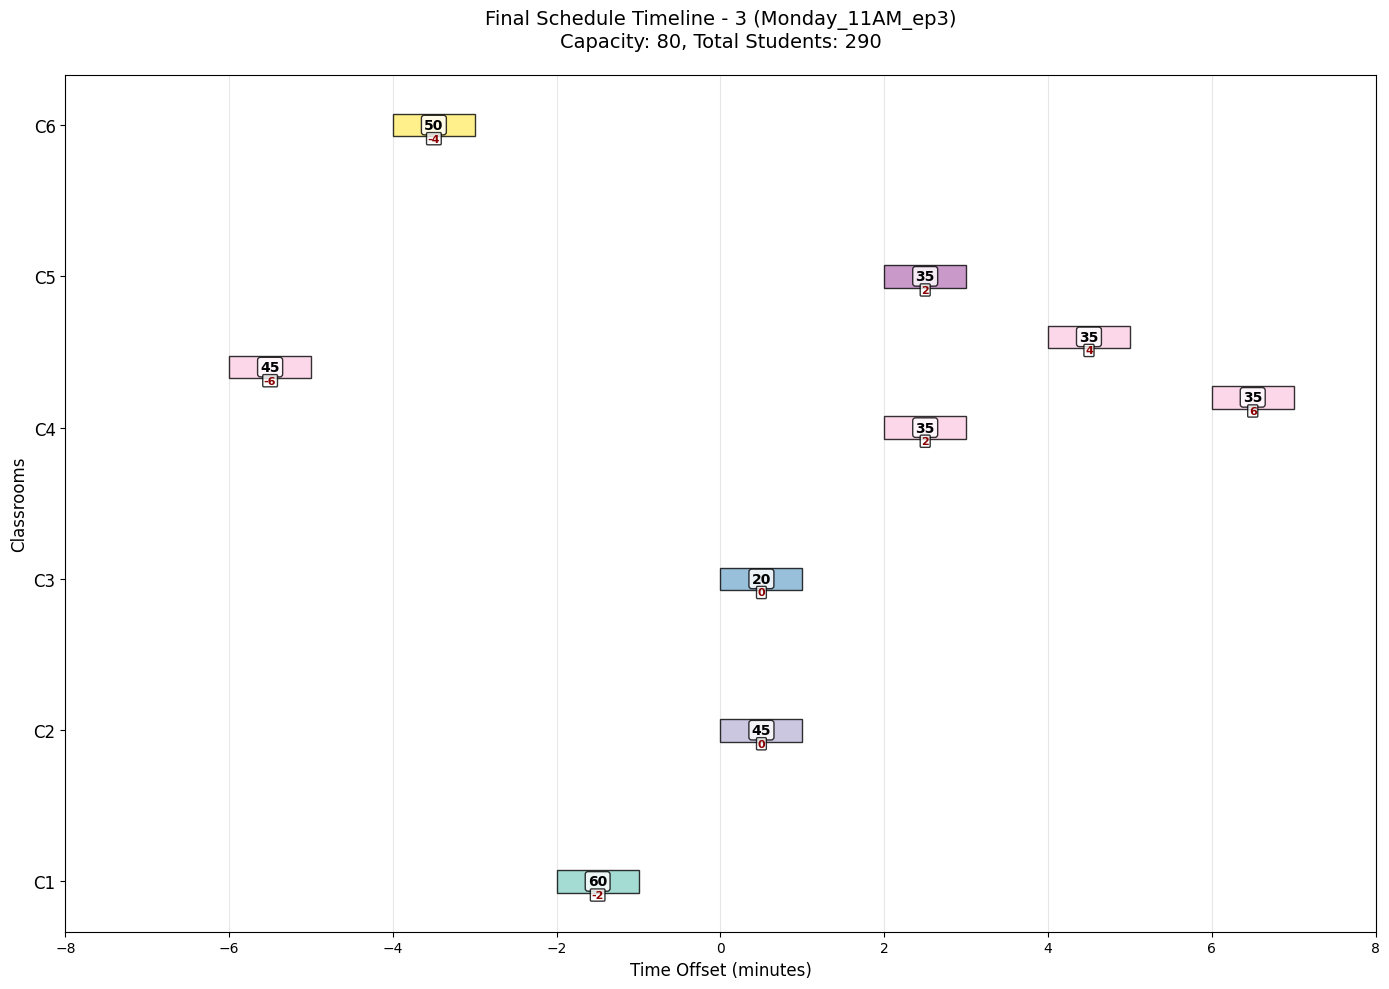


EPISODE SUMMARY: 4 (Monday_11AM_ep4)
Broadcast: Capacity=80, Total Students=290

Multiple Offers Between Pairs (2):
  C4 → C5: 2 offers
    1. direct rejected (shift: N/A)
    2. direct rejected (shift: N/A)
  C5 → C4: 2 offers
    1. counter accepted (shift: 2)
    2. counter accepted (shift: 4)

Accepted Direct Proposals (2):
  1. C4 → C1: shift -2 min
  2. C4 → C6: shift -4 min

Rejected Direct Proposals (2):
  1. C4 → C5
  2. C4 → C5

Accepted Counter Offers (2):
  1. C5 → C4: shift +2 min
  2. C5 → C4: shift +4 min

Fulfillments (2):
  ✓ C2 fulfilled com_counter_C2_to_C4_ep3 by giving 45 to C4 at slot 6
  ✓ C2 fulfilled com_offer_C2_to_C4_ep3 by giving 45 to C4 at slot 4

Violations (2):
  ⚠ C4 exceeded violation threshold for com_offer_C4_to_C1_ep3. Reputation penalized.
  ⚠ C4 exceeded violation threshold for com_offer_C4_to_C6_ep3. Reputation penalized.

Final Schedules:
  C1: offset=-2, size=60
  C2: offset=2, size=45
  C3: offset=0, size=20
  C4: offset=0, size=10, offset=6,

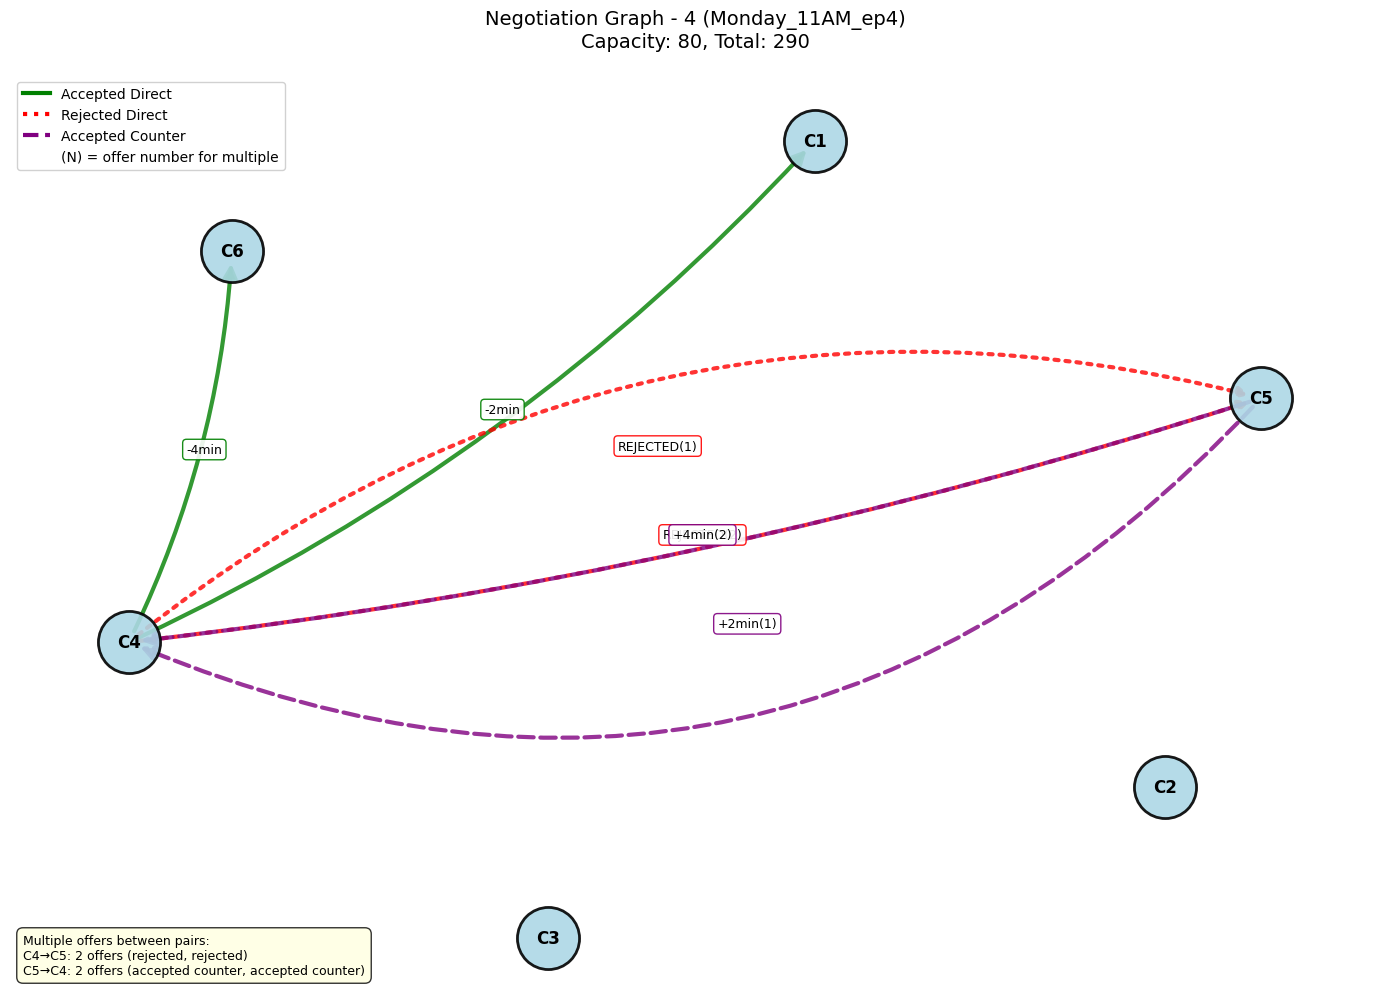

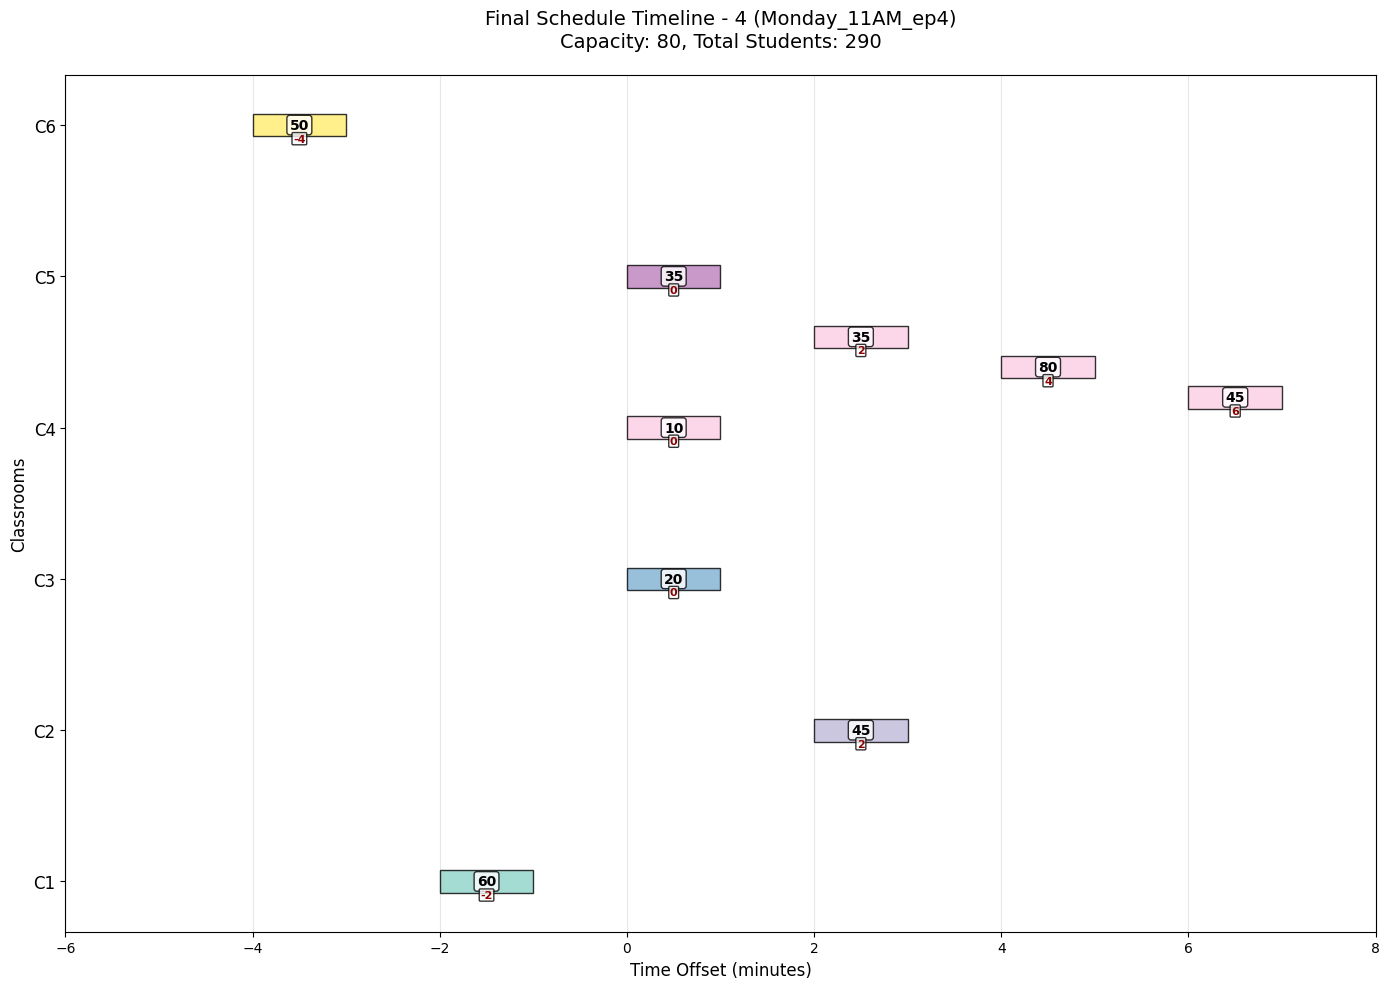


EPISODE SUMMARY: 5 (Monday_11AM_ep5)
Broadcast: Capacity=80, Total Students=290

Accepted Direct Proposals (3):
  1. C4 → C1: shift -2 min
  2. C4 → C6: shift -4 min
  3. C4 → C2: shift -6 min

Rejected Direct Proposals (1):
  1. C4 → C3

Accepted Counter Offers (1):
  1. C3 → C4: shift -6 min

Fulfillments (2):
  ✓ C5 fulfilled com_counter_C5_to_C4_ep4 by giving 35 to C4 at slot 2
  ✓ C5 fulfilled com_counter_C5_to_C4_ep4 by giving 35 to C4 at slot 4

Violations (2):
  ⚠ C4 exceeded violation threshold for com_offer_C4_to_C1_ep4. Reputation penalized.
  ⚠ C4 exceeded violation threshold for com_offer_C4_to_C6_ep4. Reputation penalized.

Final Schedules:
  C1: offset=-2, size=60
  C2: offset=-6, size=45
  C3: offset=0, size=20
  C4: offset=0, size=60, offset=2, size=35, offset=4, size=35, offset=-6, size=20
  C5: offset=2, size=35
  C6: offset=-4, size=50


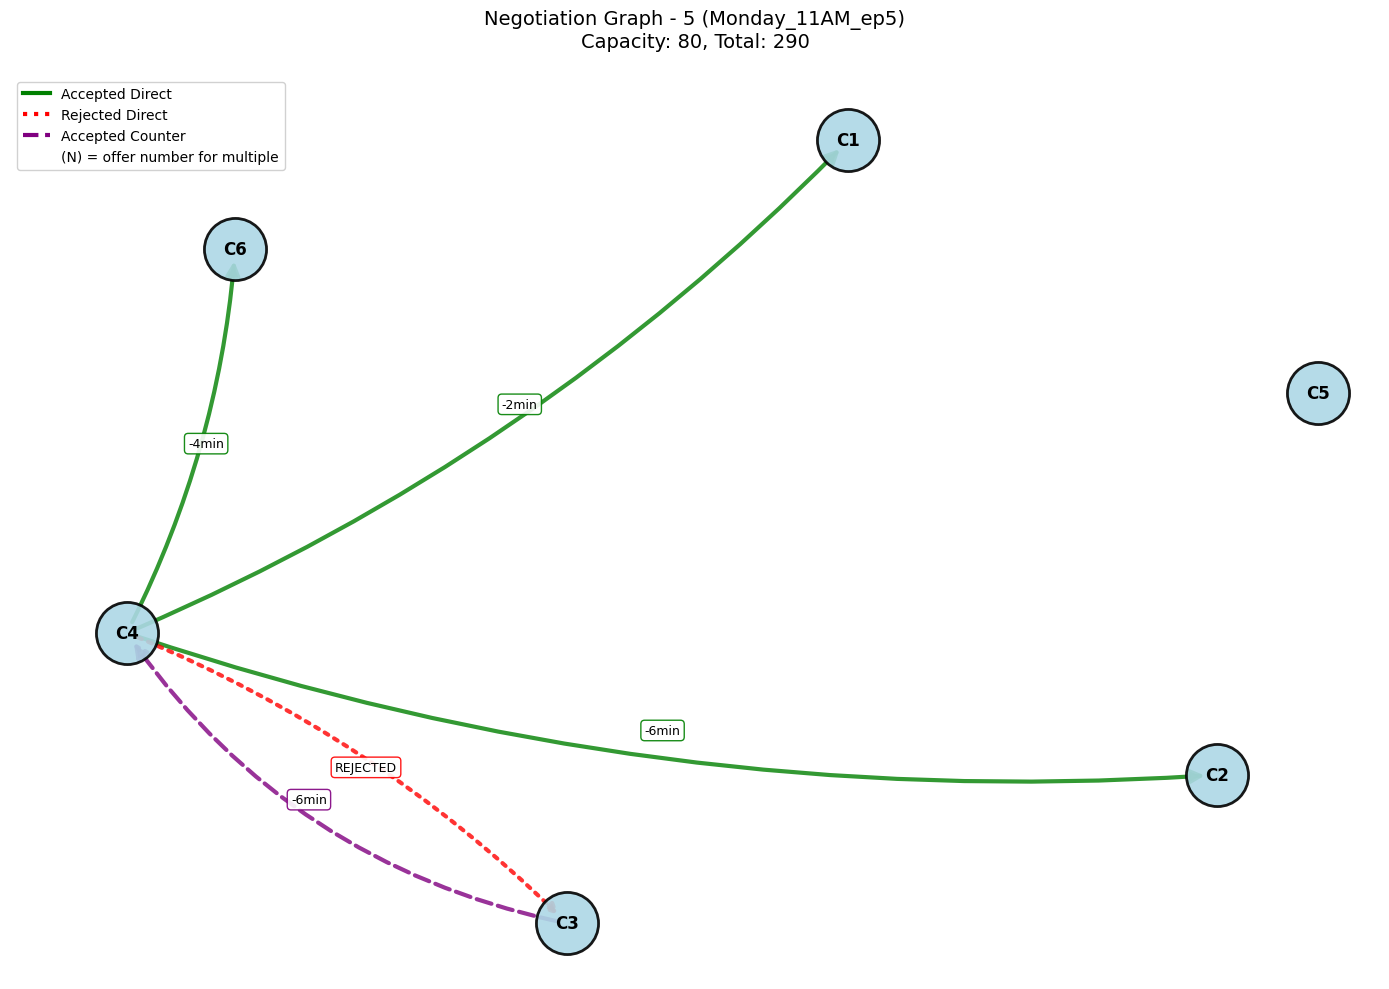

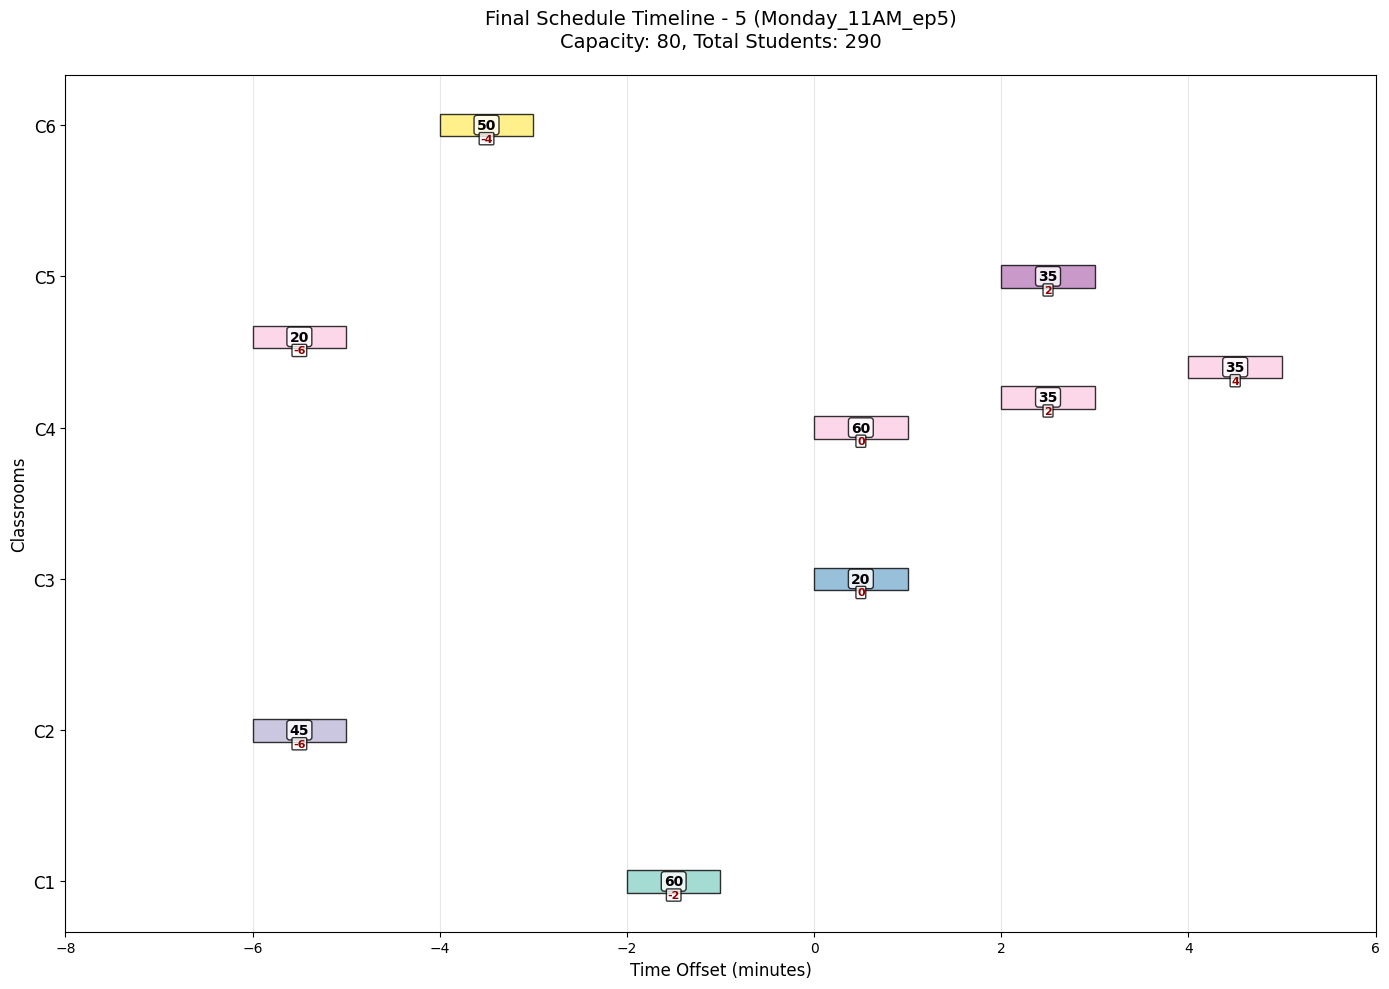

In [21]:
import re
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict

# === Step 1: Parse Logs into Structured Data ===
def parse_logs(log_text):
    episodes = []
    episode_blocks = log_text.strip().split("========================================")

    for block in episode_blocks:
        block = block.strip()
        if not block or not block.startswith("RUNNING EPISODE"):
            continue

        lines = block.splitlines()
        ep_name = lines[0].replace("RUNNING EPISODE ", "").strip()

        proposals = []
        schedules = {}
        broadcast_info = None
        fulfillment_info = []
        violation_info = []

        # Regex patterns for new format
        proposal_accepted_re = re.compile(r"\[(C\d+)\]'s offer to shift by ([+-]?\d+) min was ACCEPTED by \[(C\d+)\]")
        proposal_rejected_re = re.compile(r"\[(C\d+)\]'s offer was REJECTED by \[(C\d+)\]\.")
        counter_offer_re = re.compile(r"\[(C\d+)\] counters with a proposal to shift by ([+-]?\d+) min\.")
        counter_accept_re = re.compile(r"\[(C\d+)\] ACCEPTS the counter-offer from \[(C\d+)\]")
        schedule_re = re.compile(r"(C\d+): \[(.*?)\]")
        broadcast_re = re.compile(r"\[B\] broadcast: per_batch_capacity = (\d+), total_est=(\d+)")
        fulfilled_re = re.compile(r"\[FULFILLED\] (.*)")
        violation_re = re.compile(r"\[VIOLATION\] (.*)")

        current_negotiation_round = None
        last_rejected_proposal = None

        for line in lines:
            # Broadcast info
            m = broadcast_re.search(line)
            if m:
                broadcast_info = {
                    "per_batch_capacity": int(m.group(1)),
                    "total_est": int(m.group(2))
                }

            # Fulfillment info
            m = fulfilled_re.search(line)
            if m and "FULFILLED" in line:
                fulfillment_info.append(m.group(1))

            # Violation info
            m = violation_re.search(line)
            if m and "VIOLATION" in line:
                violation_info.append(m.group(1))

            # Negotiation rounds
            if "Negotiation round" in line:
                current_negotiation_round = int(re.search(r"Negotiation round (\d+)", line).group(1))

            # Accepted proposal with shift
            m = proposal_accepted_re.search(line)
            if m:
                proposals.append({
                    "from": m.group(1),
                    "to": m.group(3),
                    "shift": int(m.group(2)),
                    "status": "accepted",
                    "type": "direct",
                    "round": current_negotiation_round
                })

            # Rejected proposal
            m = proposal_rejected_re.search(line)
            if m:
                # Store rejected proposal
                last_rejected_proposal = {
                    "from": m.group(1),
                    "to": m.group(2),
                    "status": "rejected",
                    "type": "direct",
                    "round": current_negotiation_round
                }
                # Add to proposals immediately
                proposals.append(last_rejected_proposal.copy())

            # Counter offer
            m = counter_offer_re.search(line)
            if m and last_rejected_proposal:
                # The counter is from the rejecter back to the original proposer
                counter_proposal = {
                    "from": last_rejected_proposal["to"],  # Rejecter becomes proposer
                    "to": last_rejected_proposal["from"],  # Original proposer becomes target
                    "shift": int(m.group(2)),
                    "status": "counter_offered",
                    "type": "counter",
                    "round": current_negotiation_round
                }
                proposals.append(counter_proposal)

            # Counter acceptance
            m = counter_accept_re.search(line)
            if m:
                # Find the most recent counter offer and mark it as accepted
                for prop in reversed(proposals):
                    if (prop["type"] == "counter" and
                        prop["from"] == m.group(2) and  # Counter offerer
                        prop["to"] == m.group(1) and    # Acceptor
                        prop.get("status") == "counter_offered"):
                        prop["status"] = "accepted"
                        break

            # Schedules - handle multiple slots per classroom
            m = schedule_re.search(line)
            if m and "Schedules" not in line:  # Avoid the "Schedules:" header
                cls = m.group(1)
                slots_text = m.group(2)
                # Parse multiple slots like "(-4, 50), (4, 30)"
                slots = []
                for slot_match in re.finditer(r"\(([+-]?\d+),\s*(\d+)\)", slots_text):
                    offset = int(slot_match.group(1))
                    size = int(slot_match.group(2))
                    slots.append((offset, size))
                schedules[cls] = slots

        episodes.append({
            "name": ep_name,
            "proposals": proposals,
            "schedules": schedules,
            "broadcast": broadcast_info,
            "fulfillments": fulfillment_info,
            "violations": violation_info
        })

    return episodes


# === Step 2: Simplified and Clear Visualization Functions ===
def plot_negotiation_graph(episode):
    G = nx.DiGraph()

    # Add nodes for all classrooms mentioned in schedules and proposals
    all_classrooms = set()
    for cls in episode["schedules"].keys():
        all_classrooms.add(cls)
    for prop in episode["proposals"]:
        all_classrooms.add(prop["from"])
        all_classrooms.add(prop["to"])

    for classroom in sorted(all_classrooms):
        G.add_node(classroom)

    if len(episode["proposals"]) == 0:
        print(f"No negotiation proposals to plot for {episode['name']}")
        return

    # Track multiple offers between same classrooms with counts and details
    offer_details = defaultdict(list)

    for prop in episode["proposals"]:
        key = (prop["from"], prop["to"])
        offer_details[key].append({
            "type": prop["type"],
            "status": prop["status"],
            "shift": prop.get("shift", None),
            "round": prop.get("round", None)
        })

    # Group proposals by type and status for clearer visualization
    accepted_direct = []
    rejected_direct = []
    counter_offers = []
    accepted_counters = []

    for prop in episode["proposals"]:
        if prop["type"] == "direct":
            if prop["status"] == "accepted":
                accepted_direct.append(prop)
            else:
                rejected_direct.append(prop)
        else:  # counter
            if prop["status"] == "accepted":
                accepted_counters.append(prop)
            else:
                counter_offers.append(prop)

    # Create a layout with better spacing
    pos = nx.spring_layout(G, k=3, iterations=100, seed=42)

    plt.figure(figsize=(14, 10))

    # Draw nodes
    nx.draw_networkx_nodes(G, pos, node_size=2000, node_color="lightblue",
                          edgecolors='black', linewidths=2, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight="bold")

    # Function to draw multiple edges between same nodes
    def draw_multiple_edges(proposals, color, style, arrow_size, base_rad, label_prefix=""):
        edge_groups = defaultdict(list)

        # Group proposals by (from, to) pair
        for prop in proposals:
            key = (prop["from"], prop["to"])
            edge_groups[key].append(prop)

        # Draw each group
        for key, props in edge_groups.items():
            from_node, to_node = key
            num_edges = len(props)

            # Draw multiple curved edges for the same pair
            for i, prop in enumerate(props):
                # Calculate curvature - spread edges
                if num_edges == 1:
                    rad = base_rad
                else:
                    # Spread edges evenly around base_rad
                    spread = 0.3
                    rad = base_rad + (i - (num_edges - 1) / 2) * (spread / max(1, num_edges - 1))

                # Draw the edge
                nx.draw_networkx_edges(
                    G, pos, edgelist=[(from_node, to_node)],
                    edge_color=color, width=3, alpha=0.8, style=style,
                    arrows=True, arrowstyle='-|>', arrowsize=arrow_size,
                    connectionstyle=f"arc3,rad={rad}"
                )

                # Add label with shift value
                shift_value = prop.get("shift")
                if shift_value is not None:
                    label = f"{shift_value:+d}min"
                else:
                    label = label_prefix

                # Calculate label position
                x = (pos[from_node][0] + pos[to_node][0]) / 2
                y = (pos[from_node][1] + pos[to_node][1]) / 2


                # Offset label dynamically to avoid overlap

                if num_edges == 1:
                    rad = base_rad
                else:
                    spread = 0.3
                    rad = base_rad + (i - (num_edges - 1) / 2) * (spread / max(1, num_edges - 1))

                # Calculate label offset separately, using a smaller multiplier
                label_offset_factor = 0.4  # smaller factor keeps text closer
                offset_x = (pos[to_node][1] - pos[from_node][1]) * rad * label_offset_factor
                offset_y = (pos[from_node][0] - pos[to_node][0]) * rad * label_offset_factor


                # For multiple edges, add index indicator
                if num_edges > 1:
                    label = f"{label}({i+1})"

                plt.text(x + offset_x, y + offset_y, label, fontsize=9, ha='center', va='center',
                        bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor=color))

    # Draw accepted direct edges (green, solid)
    draw_multiple_edges(accepted_direct, 'green', 'solid', 20, 0.1, "accepted")

    # Draw rejected direct edges (red, dotted) - made more visible
    draw_multiple_edges(rejected_direct, 'red', 'dotted', 15, -0.1, "REJECTED")

    # Draw counter offers (bright yellow with dark outline for visibility)
    for prop in counter_offers:
        # Group counter offers by pair
        key = (prop["from"], prop["to"])
        props = [p for p in counter_offers if (p["from"], p["to"]) == key]
        num_edges = len(props)
        current_index = props.index(prop)

        # Calculate curvature
        if num_edges == 1:
            rad = 0.2
        else:
            spread = 0.4
            rad = 0.2 + (current_index - (num_edges - 1) / 2) * (spread / max(1, num_edges - 1))

        # Draw with bright yellow and dark outline for visibility
        nx.draw_networkx_edges(
            G, pos, edgelist=[(prop["from"], prop["to"])],
            edge_color='yellow', width=4, alpha=0.9, style='dashed',
            arrows=True, arrowstyle='-|>', arrowsize=18,
            connectionstyle=f"arc3,rad={rad}"
        )
        # Add dark outline for better visibility
        nx.draw_networkx_edges(
            G, pos, edgelist=[(prop["from"], prop["to"])],
            edge_color='black', width=5, alpha=0.3, style='dashed',
            arrows=True, arrowstyle='-|>', arrowsize=18,
            connectionstyle=f"arc3,rad={rad}"
        )

        # Add label
        shift_value = prop.get("shift", "?")
        label = f"{shift_value}min" if shift_value != "?" else "counter"
        if num_edges > 1:
            label = f"{label}({current_index + 1})"

        x = (pos[prop["from"]][0] + pos[prop["to"]][0]) / 2
        y = (pos[prop["from"]][1] + pos[prop["to"]][1]) / 2
        offset_x = (pos[prop["to"]][1] - pos[prop["from"]][1]) * rad * 0.8
        offset_y = (pos[prop["from"]][0] - pos[prop["to"]][0]) * rad * 0.8

        plt.text(x + offset_x, y + offset_y, label, fontsize=9, ha='center', va='center',
                bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.9, edgecolor='orange'))

    # Draw accepted counters (purple, dashed)
    draw_multiple_edges(accepted_counters, 'purple', 'dashed', 20, -0.2, "accepted counter")

    # Add summary of multiple offers
    multi_offer_summary = []
    for (from_node, to_node), offers in offer_details.items():
        if len(offers) > 1:
            offer_types = []
            for offer in offers:
                if offer['type'] == 'direct':
                    if offer['status'] == 'accepted':
                        offer_types.append("accepted")
                    else:
                        offer_types.append("rejected")
                else:
                    if offer['status'] == 'accepted':
                        offer_types.append("accepted counter")
                    else:
                        offer_types.append("counter")
            multi_offer_summary.append(f"{from_node}→{to_node}: {len(offers)} offers ({', '.join(offer_types)})")

    if multi_offer_summary:
        summary_text = "Multiple offers between pairs:\n" + "\n".join(multi_offer_summary)
        plt.figtext(0.02, 0.02, summary_text, fontsize=9,
                   bbox=dict(boxstyle="round,pad=0.5", facecolor="lightyellow", alpha=0.8))

    # Create comprehensive legend
    legend_elements = [
        plt.Line2D([0], [0], color='green', lw=3, label='Accepted Direct'),
        plt.Line2D([0], [0], color='red', lw=3, linestyle='dotted', label='Rejected Direct'),
        plt.Line2D([0], [0], color='purple', lw=3, linestyle='dashed', label='Accepted Counter'),
        plt.Line2D([0], [0], color='black', lw=0, label='(N) = offer number for multiple'),
    ]
    plt.legend(handles=legend_elements, loc='upper left', framealpha=0.9)

    # Add broadcast info to title if available
    title = f"Negotiation Graph - {episode['name']}"
    if episode.get("broadcast"):
        bc = episode["broadcast"]
        title += f"\nCapacity: {bc['per_batch_capacity']}, Total: {bc['total_est']}"

    plt.title(title, fontsize=14, pad=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()


def plot_schedule_timeline(episode):
    schedules = episode["schedules"]
    if not schedules:
        print(f"No schedules to plot for {episode['name']}")
        return

    classrooms = sorted(schedules.keys(), key=lambda x: int(x[1:]))  # Sort by classroom number

    fig, ax = plt.subplots(figsize=(14, 10))

    yticks, ylabels = [], []
    colors = plt.cm.Set3(np.linspace(0, 1, len(classrooms)))

    for i, cls in enumerate(classrooms):
        slots = schedules[cls]
        base_y = i * 20  # Increased spacing for multiple slots

        for j, (offset, size) in enumerate(slots):
            # Create a bar for each slot with different colors
            y_pos = base_y + j * 4  # Stack slots vertically
            color = colors[i]
            ax.barh(y_pos, width=1, left=offset, height=3, align='center',
                    color=color, edgecolor='black', alpha=0.8)

            # Add text label with size (ensure it's always visible)
            ax.text(offset + 0.5, y_pos, f"{size}", va='center', ha='center',
                    fontsize=10, fontweight='bold', color='black',
                    bbox=dict(boxstyle="round,pad=0.2", facecolor="white", alpha=0.8))

            # Add offset label below the bar (ensure it's always visible)
            ax.text(offset + 0.5, y_pos - 1.8, f"{offset}", va='center', ha='center',
                   fontsize=8, color='darkred', fontweight='bold',
                   bbox=dict(boxstyle="round,pad=0.1", facecolor="white", alpha=0.8))

            # Add classroom label for the first slot only
            if j == 0:
                yticks.append(y_pos)
                ylabels.append(cls)

    ax.set_yticks(yticks)
    ax.set_yticklabels(ylabels, fontsize=12)
    ax.set_xlabel("Time Offset (minutes)", fontsize=12)
    ax.set_ylabel("Classrooms", fontsize=12)

    # Add broadcast info to title if available
    title = f"Final Schedule Timeline - {episode['name']}"
    if episode.get("broadcast"):
        bc = episode["broadcast"]
        title += f"\nCapacity: {bc['per_batch_capacity']}, Total Students: {bc['total_est']}"

    plt.title(title, fontsize=14, pad=20)

    # Add grid for better readability
    ax.grid(True, axis='x', alpha=0.3)
    ax.set_axisbelow(True)

    # Set x-axis limits with some padding
    all_offsets = [offset for slots in schedules.values() for offset, size in slots]
    if all_offsets:
        min_offset = min(all_offsets)
        max_offset = max(all_offsets)
        ax.set_xlim(min_offset - 2, max_offset + 2)

    plt.tight_layout()
    plt.show()


def print_episode_summary(episode):
    """Print a detailed text summary of the episode"""
    print(f"\n{'='*60}")
    print(f"EPISODE SUMMARY: {episode['name']}")
    print(f"{'='*60}")

    if episode.get("broadcast"):
        bc = episode["broadcast"]
        print(f"Broadcast: Capacity={bc['per_batch_capacity']}, Total Students={bc['total_est']}")

    # Group proposals by type for summary
    accepted_direct = [p for p in episode['proposals'] if p['type'] == 'direct' and p['status'] == 'accepted']
    rejected_direct = [p for p in episode['proposals'] if p['type'] == 'direct' and p['status'] == 'rejected']
    counter_offers = [p for p in episode['proposals'] if p['type'] == 'counter' and p['status'] != 'accepted']
    accepted_counters = [p for p in episode['proposals'] if p['type'] == 'counter' and p['status'] == 'accepted']

    # Check for multiple offers between same pairs
    offer_pairs = defaultdict(list)
    for prop in episode['proposals']:
        key = (prop['from'], prop['to'])
        offer_pairs[key].append(prop)

    multiple_offers = {k: v for k, v in offer_pairs.items() if len(v) > 1}

    if multiple_offers:
        print(f"\nMultiple Offers Between Pairs ({len(multiple_offers)}):")
        for (from_cls, to_cls), offers in multiple_offers.items():
            print(f"  {from_cls} → {to_cls}: {len(offers)} offers")
            for i, offer in enumerate(offers, 1):
                offer_type = "direct" if offer['type'] == 'direct' else "counter"
                status = offer['status']
                shift = offer.get('shift', 'N/A')
                print(f"    {i}. {offer_type} {status} (shift: {shift})")

    if accepted_direct:
        print(f"\nAccepted Direct Proposals ({len(accepted_direct)}):")
        for i, prop in enumerate(accepted_direct, 1):
            shift_value = prop.get('shift', '?')
            shift_str = f"{shift_value:+d} min" if isinstance(shift_value, int) else f"{shift_value} min"
            print(f"  {i}. {prop['from']} → {prop['to']}: shift {shift_str}")

    if rejected_direct:
        print(f"\nRejected Direct Proposals ({len(rejected_direct)}):")
        for i, prop in enumerate(rejected_direct, 1):
            print(f"  {i}. {prop['from']} → {prop['to']}")

    if counter_offers:
        print(f"\nCounter Offers ({len(counter_offers)}):")
        for i, prop in enumerate(counter_offers, 1):
            shift_value = prop.get('shift', '?')
            shift_str = f"{shift_value:+d} min" if isinstance(shift_value, int) else f"{shift_value} min"
            print(f"  {i}. {prop['from']} → {prop['to']}: shift {shift_str}")

    if accepted_counters:
        print(f"\nAccepted Counter Offers ({len(accepted_counters)}):")
        for i, prop in enumerate(accepted_counters, 1):
            shift_value = prop.get('shift', '?')
            shift_str = f"{shift_value:+d} min" if isinstance(shift_value, int) else f"{shift_value} min"
            print(f"  {i}. {prop['from']} → {prop['to']}: shift {shift_str}")

    if episode.get('fulfillments'):
        print(f"\nFulfillments ({len(episode['fulfillments'])}):")
        for fulfillment in episode['fulfillments']:
            print(f"  ✓ {fulfillment}")

    if episode.get('violations'):
        print(f"\nViolations ({len(episode['violations'])}):")
        for violation in episode['violations']:
            print(f"  ⚠ {violation}")

    print(f"\nFinal Schedules:")
    for cls in sorted(episode['schedules'].keys(), key=lambda x: int(x[1:])):
        slots = episode['schedules'][cls]
        slot_str = ", ".join([f"offset={offset}, size={size}" for offset, size in slots])
        print(f"  {cls}: {slot_str}")


# === Step 3: Run ===
if __name__ == "__main__":
    # Read log file
    with open("logs.txt", "r") as f:
        log_text = f.read()

    episodes = parse_logs(log_text)

    print(f"Parsed {len(episodes)} episodes")

    # Visualize all episodes
    for i, ep in enumerate(episodes):
        print_episode_summary(ep)
        plot_negotiation_graph(ep)
        plot_schedule_timeline(ep)